# Analysis of our Network

In [44]:
import networkx as nx
from shapely import wkt
import json
import matplotlib.pyplot as plt
import time
import networkx.algorithms.community as nxcom
import os
import numpy as np

In [45]:
G = nx.read_gml("county_graph_with_ntl.gml")

# Convert the 'geometry' from WKT string back to Shapely geometry and 'ntl' from JSON string back to dictionary
for node, data in G.nodes(data=True):
    if 'geometry' in data:
        data['geometry'] = wkt.loads(data['geometry'])
    if 'ntl' in data:
        data['ntl'] = json.loads(data['ntl'])

# Verify the conversion
first_node = list(G.nodes(data=True))[0]
print(first_node)

('Georgia_Appling', {'state': 'Georgia', 'county': 'Appling', 'geometry': <MULTIPOLYGON (((-82.227 31.531, -82.228 31.532, -82.228 31.533, -82.229 31....>, 'ntl': {'2023-09-01': {'2023-09-01_sum': 55178.0, '2023-09-01_avg': 3.8318055555555555}, '2023-09-02': {'2023-09-02_sum': 43314.0, '2023-09-02_avg': 3.0079166666666666}, '2023-09-03': {'2023-09-03_sum': 50646.0, '2023-09-03_avg': 3.5170833333333333}, '2023-09-04': {'2023-09-04_sum': 81750.0, '2023-09-04_avg': 5.677083333333333}, '2023-09-05': {'2023-09-05_sum': 54391.0, '2023-09-05_avg': 3.777152777777778}, '2023-09-06': {'2023-09-06_sum': 55446.0, '2023-09-06_avg': 3.850416666666667}, '2023-09-07': {'2023-09-07_sum': 59246.0, '2023-09-07_avg': 4.114305555555555}, '2023-09-08': {'2023-09-08_sum': 59283.0, '2023-09-08_avg': 4.116875}, '2023-09-09': {'2023-09-09_sum': 80733.0, '2023-09-09_avg': 5.606458333333333}, '2023-09-10': {'2023-09-10_sum': 77241.0, '2023-09-10_avg': 5.363958333333334}, '2023-09-11': {'2023-09-11_sum': 71635.0, 

In [4]:
print(G)

Graph with 205 nodes and 567 edges


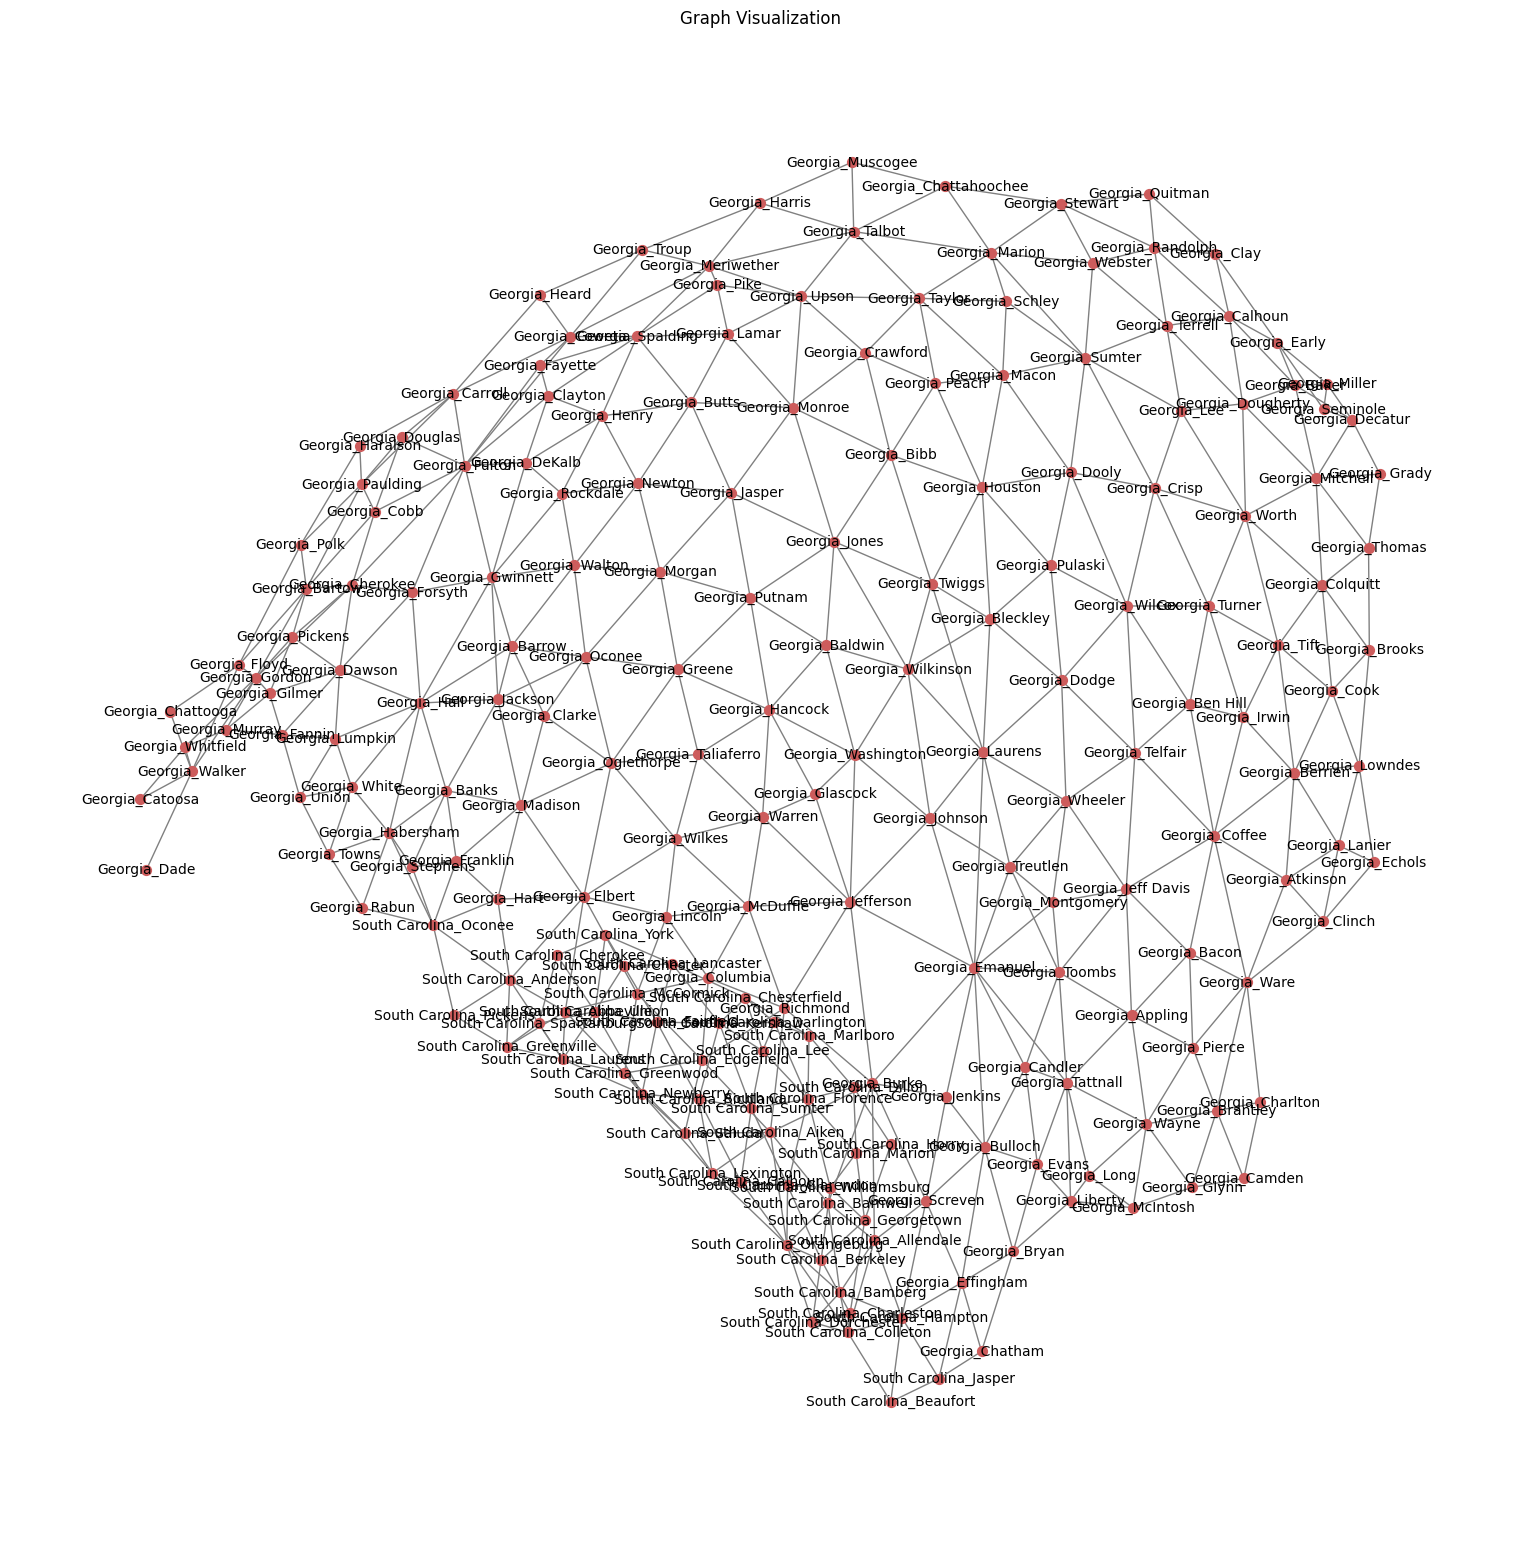

In [ ]:
# Draw the graph

# Ensure the output directory exists
os.makedirs("visualizations", exist_ok=True)

# Define the graph layout
pos = nx.spring_layout(G, seed=39)  # Choose a layout, e.g., spring layout

# Draw the graph
plt.figure(figsize=(15, 15))
nx.draw(
    G, pos, 
    with_labels=True, 
    node_size=50, 
    font_size=10, 
    edge_color="gray", 
    node_color="indianred"
)
plt.title("Graph Visualization")
plt.savefig('visualizations/graph_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Nearest Neighbor Analysis
**Objective:** Analyze how the degree of a node's neighbors depends on the node's degree. Compute the average degree of neighbors knn(k) for nodes with degree k.

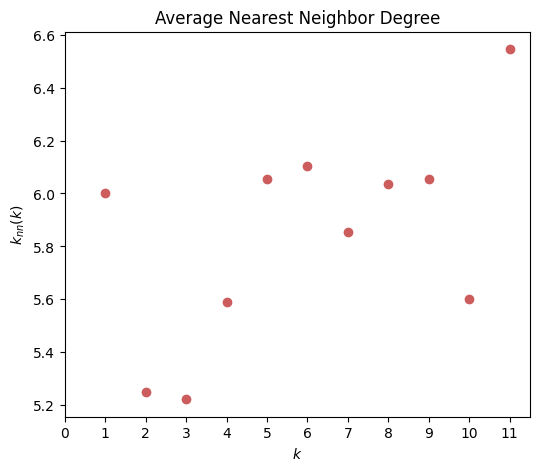

In [51]:
# Calculate the degree of each node
node_degrees = dict(G.degree())

# Compute the average neighbor degree of each node
avg_neighbor_degree = nx.average_neighbor_degree(G)

# Group by degree to compute knn(k) as a function of degree
degree_knn = {}
for node, degree in node_degrees.items():
    if degree not in degree_knn:
        degree_knn[degree] = []
    degree_knn[degree].append(avg_neighbor_degree[node])

# Calculate the average knn(k) for each degree
degrees = sorted(degree_knn.keys())
knn_values = [np.mean(degree_knn[degree]) for degree in degrees]


# plot
plt.figure(figsize=(6, 5))
plt.plot(degrees, knn_values, 'o', color='indianred', label="knn(k)")
plt.xlabel("$k$")
plt.xticks(range(12))
plt.ylabel("$k_{nn}(k)$")
plt.title('Average Nearest Neighbor Degree')
plt.show()

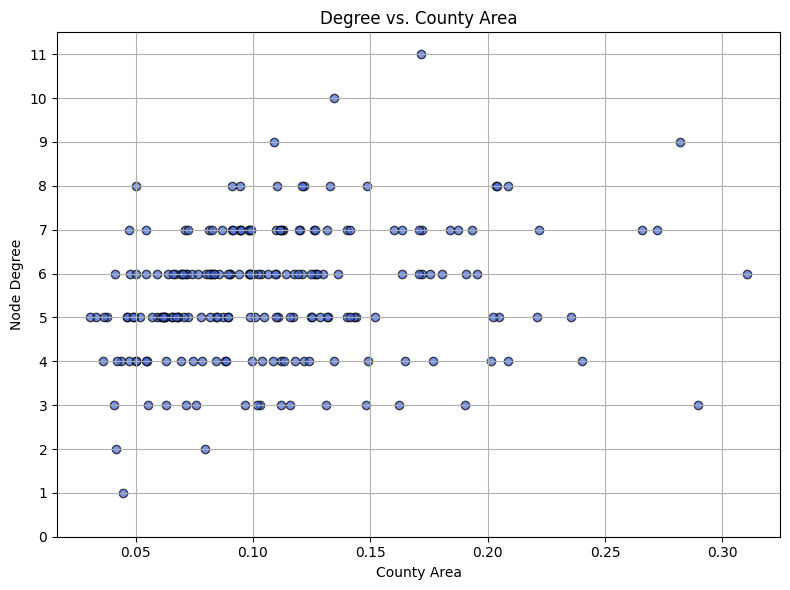

In [52]:
# Extract areas of counties and degrees of nodes
areas = {data["state"]+"_"+data["county"]: data["geometry"].area for node, data in G.nodes(data=True)}
degrees = dict(G.degree())

# Ensure the nodes in areas and degrees match
common_nodes = set(areas.keys()) & set(degrees.keys())

# Filter data to only include common nodes
areas_filtered = [areas[node] for node in common_nodes]
degrees_filtered = [degrees[node] for node in common_nodes]

# Plot degree vs. area
plt.figure(figsize=(8, 6))
plt.scatter(areas_filtered, degrees_filtered, alpha=0.7, edgecolors='k', c='royalblue')

# Optional: Add a trendline
z = np.polyfit(areas_filtered, degrees_filtered, 1)
p = np.poly1d(z)

# Customize plot
plt.title("Degree vs. County Area")
plt.xlabel("County Area")
plt.ylabel("Node Degree")
plt.yticks(range(12))
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


# TODO: add comment on that sanity check (wie ist network grundsätzlich aufgebaut)


# Comparison with Randomized Graphs
**Objective:** Compare the properties of the original graph with a randomized version of it to observe structural differences.

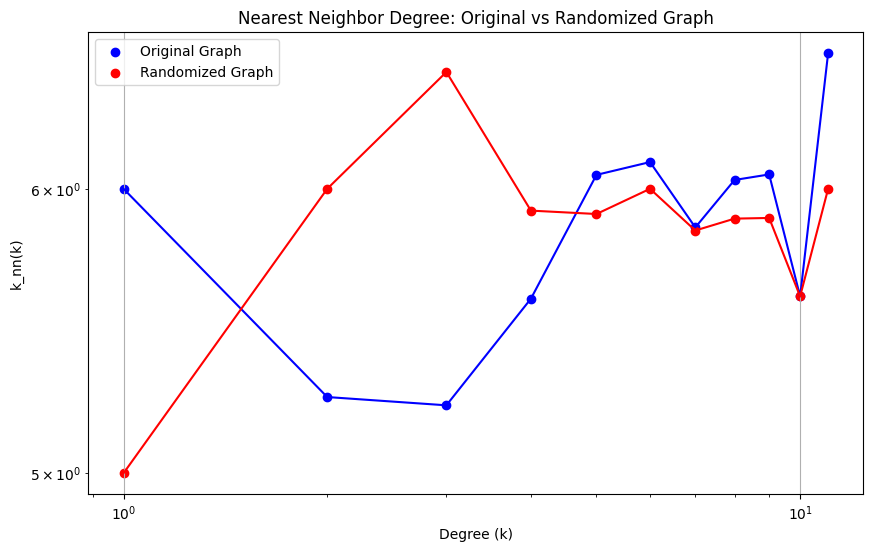

In [7]:
# Original graph: compute average nearest neighbor degree
original_knn = nx.average_neighbor_degree(G)

# Group by degree and compute averages for the original graph
original_degree_knn = {}
for node, knn_value in original_knn.items():
    degree = G.degree[node]
    if degree not in original_degree_knn:
        original_degree_knn[degree] = []
    original_degree_knn[degree].append(knn_value)

original_degrees = sorted(original_degree_knn.keys())
original_avg_knn = [sum(original_degree_knn[k]) / len(original_degree_knn[k]) for k in original_degrees]

# Randomized graph: generate a degree-preserving random graph
randomized_G = nx.random_reference(G, niter=10, seed=39)
randomized_knn = nx.average_neighbor_degree(randomized_G)

# Group by degree and compute averages for the randomized graph
randomized_degree_knn = {}
for node, knn_value in randomized_knn.items():
    degree = randomized_G.degree[node]
    if degree not in randomized_degree_knn:
        randomized_degree_knn[degree] = []
    randomized_degree_knn[degree].append(knn_value)

randomized_degrees = sorted(randomized_degree_knn.keys())
randomized_avg_knn = [sum(randomized_degree_knn[k]) / len(randomized_degree_knn[k]) for k in randomized_degrees]

# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(original_degrees, original_avg_knn, color='blue', label='Original Graph')
plt.plot(original_degrees, original_avg_knn, color='blue')
plt.scatter(randomized_degrees, randomized_avg_knn, color='red', label='Randomized Graph')
plt.plot(randomized_degrees, randomized_avg_knn, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('k_nn(k)')
plt.title('Nearest Neighbor Degree: Original vs Randomized Graph')
plt.legend()
plt.grid(True)
plt.show()


# TODO: comment on that

# Degree Probability Density in Logarithmic Scale
**Objective:** Plot the degree distribution in a log-log scale to observe if the network follows a power-law or has a characteristic scale.

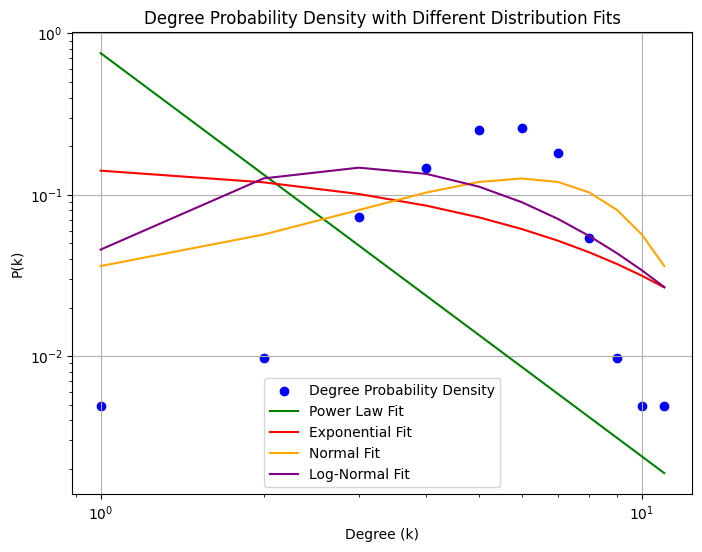

In [9]:
from scipy.stats import powerlaw, norm, lognorm, expon

# Degree calculation and degree probability density
degrees = [d for n, d in G.degree()]
degree_counts = np.bincount(degrees)
degree_prob = degree_counts / sum(degree_counts)

# Plot degree distribution
plt.figure(figsize=(8, 6))
x = np.arange(len(degree_prob))[1:]  # Exclude degree 0
y = degree_prob[1:]
plt.scatter(x, y, color='blue', label='Degree Probability Density')

# Fit and plot Power Law
alpha = 2.5  # This is a typical power law exponent (you may estimate it from your data)
powerlaw_pdf = (alpha - 1) * (x) ** (-alpha)
plt.plot(x, powerlaw_pdf / sum(powerlaw_pdf), color='green', label='Power Law Fit')

# Fit and plot Exponential Distribution
lambda_exp = 1 / np.mean(x)  # Fit lambda based on the mean degree
exponential_pdf = expon.pdf(x, scale=1/lambda_exp)
plt.plot(x, exponential_pdf, color='red', label='Exponential Fit')

# Fit and plot Normal Distribution
mean_deg = np.mean(x)
std_deg = np.std(x)
normal_pdf = norm.pdf(x, loc=mean_deg, scale=std_deg)
plt.plot(x, normal_pdf, color='orange', label='Normal Fit')

# Fit and plot Log-Normal Distribution
shape, loc, scale = lognorm.fit(x, floc=0)  # Fit log-normal to the data
lognormal_pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, lognormal_pdf, color='purple', label='Log-Normal Fit')

# Plot settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Degree Probability Density with Different Distribution Fits')
plt.grid(True)
plt.legend()
plt.show()


# TODO: comment

# Community analysis

In [9]:
# i took the code from their solutions, i have to rewrite it

In [39]:
def f(G):

    def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

    def set_edge_community(G):
        '''Find internal edges and add their community to their attributes'''
        for v, w, in G.edges:
            if G.nodes[v]['community'] == G.nodes[w]['community']:
                # Internal edge, mark with community
                G.edges[v, w]['community'] = G.nodes[v]['community']
            else:
                # External edge, mark as 0
                G.edges[v, w]['community'] = 0
    
    def get_color(i, r_off=1, g_off=1, b_off=1):
        '''Assign a color to a vertex.'''
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)   

    # CNM
    start = time.time()
    communitiesCNM = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
    print(f"The network has {len(communitiesCNM)} communities with Clauset-Newman-Moore.")
    end = time.time()
    print(end - start)
    # Set node and edge communities
    communities = communitiesCNM
    set_node_community(G, communities)
    set_edge_community(G)
    
    node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
    
    # Set community color for edges between members of the same community (internal) and intra-community edges (external)
    external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
    internal_color = ['black' for e in internal]
    
    
    pos = nx.spring_layout(G)

    # Draw external edges
    fig, ax = plt.subplots()
    nx.draw_networkx(
        G,
        pos=pos,
        node_size=0,
        edgelist=external,
        edge_color="silver",
        node_color=node_color,
        with_labels=True)
    nx.draw_networkx(
        G,
        pos=pos,
        node_color=node_color,
        edgelist=internal,
        edge_color=internal_color,
        with_labels=False)
    plt.axis("off")
    plt.savefig('visualizations/greedy_modularity.png', dpi=300, bbox_inches='tight')
    plt.show()

    # LP
    start = time.time()
    compLP = nxcom.label_propagation_communities(G)
    communitiesLP = [c for c in sorted(compLP, key=len, reverse=True)]
    print(f"The network has {len(communitiesLP)} communities with Label Propagation.")
    end = time.time()
    print(end - start)
    communities = communitiesLP
    set_node_community(G, communities)
    set_edge_community(G)
    
    node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
    
    # Set community color for edges between members of the same community (internal) and intra-community edges (external)
    external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
    internal_color = ['black' for e in internal]

    pos = nx.spring_layout(G)
    
    plt.rcParams.update({'figure.figsize': (35, 25)})
    # Draw external edges
    fig, ax = plt.subplots()
    nx.draw_networkx(
        G,
        pos=pos,
        node_size=0,
        edgelist=external,
        edge_color="silver",
        node_color=node_color,
        with_labels=False)
    nx.draw_networkx(
        G,
        pos=pos,
        node_color=node_color,
        edgelist=internal,
        edge_color=internal_color,
        with_labels=True)
    plt.axis("off")
    plt.savefig('visualizations/label_propagation.png', dpi=300, bbox_inches='tight')
    plt.show()

The network has 5 communities with Clauset-Newman-Moore.
0.07034015655517578


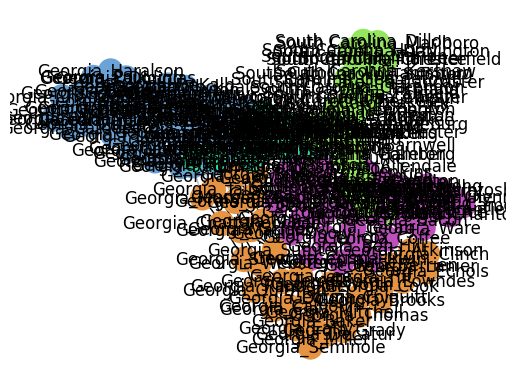

The network has 28 communities with Label Propagation.
0.005435943603515625


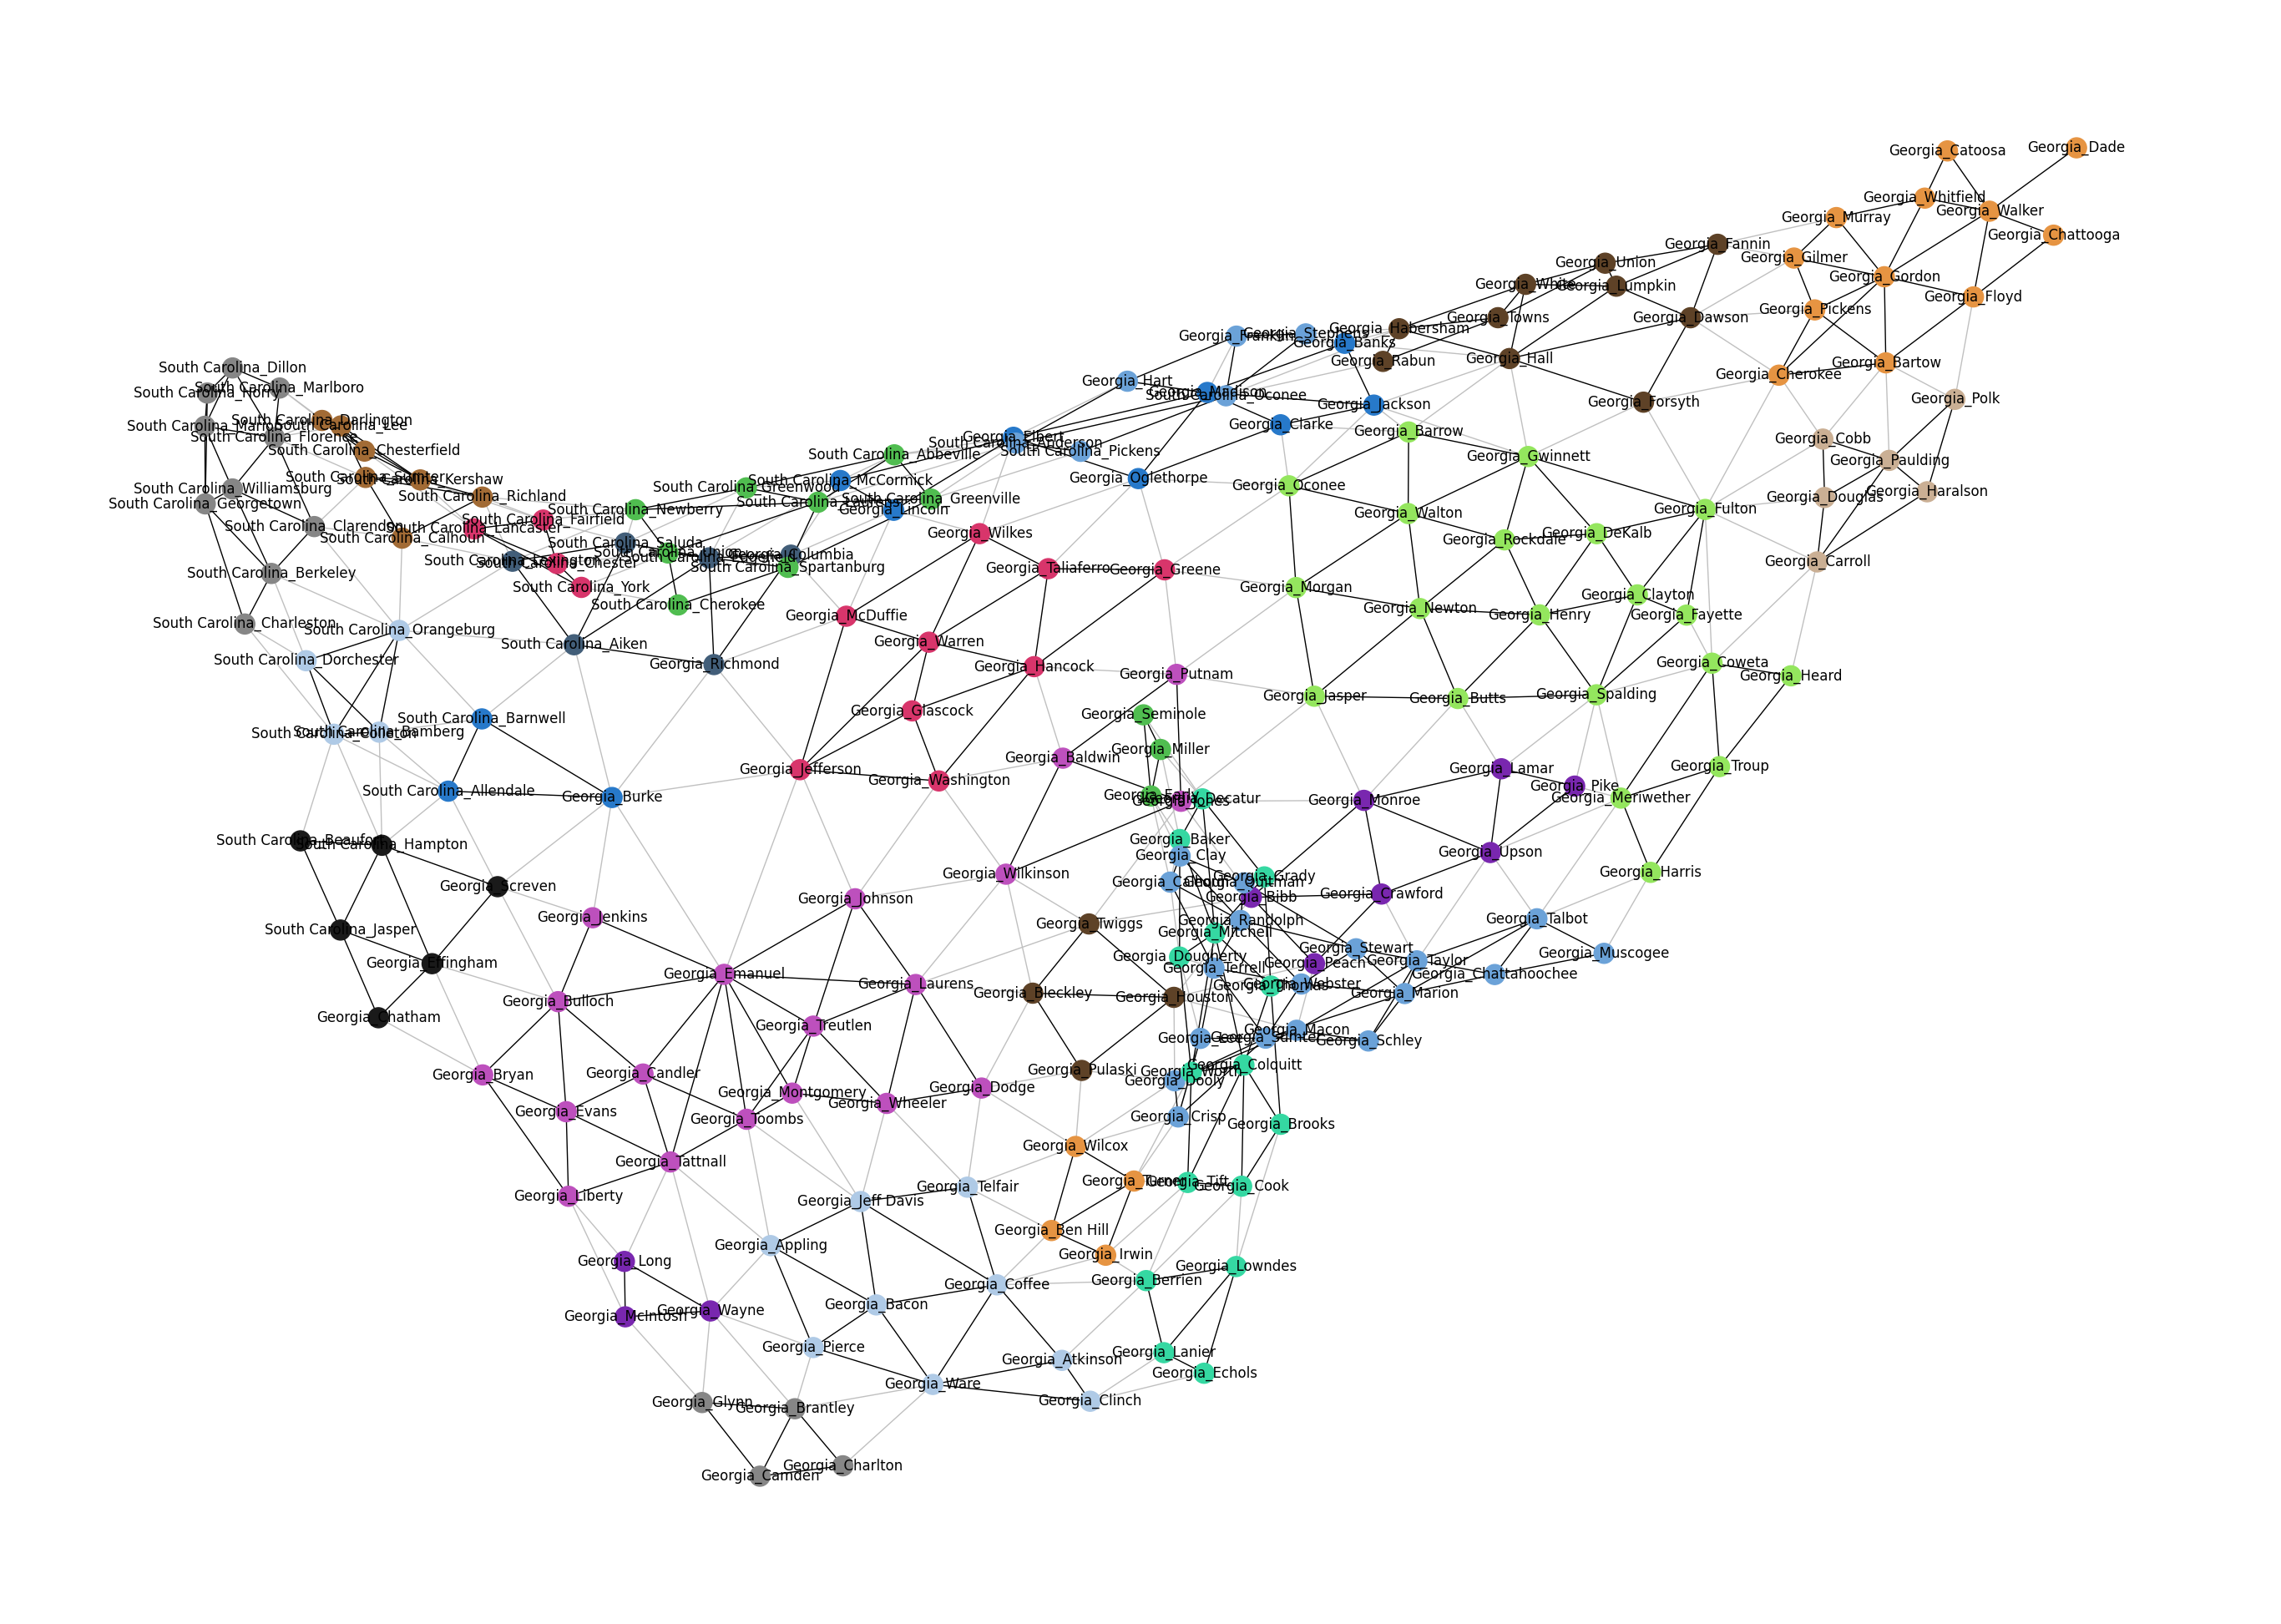

In [40]:
f(G)

The network has 8 communities with Clauset-Newman-Moore.
0.07051515579223633


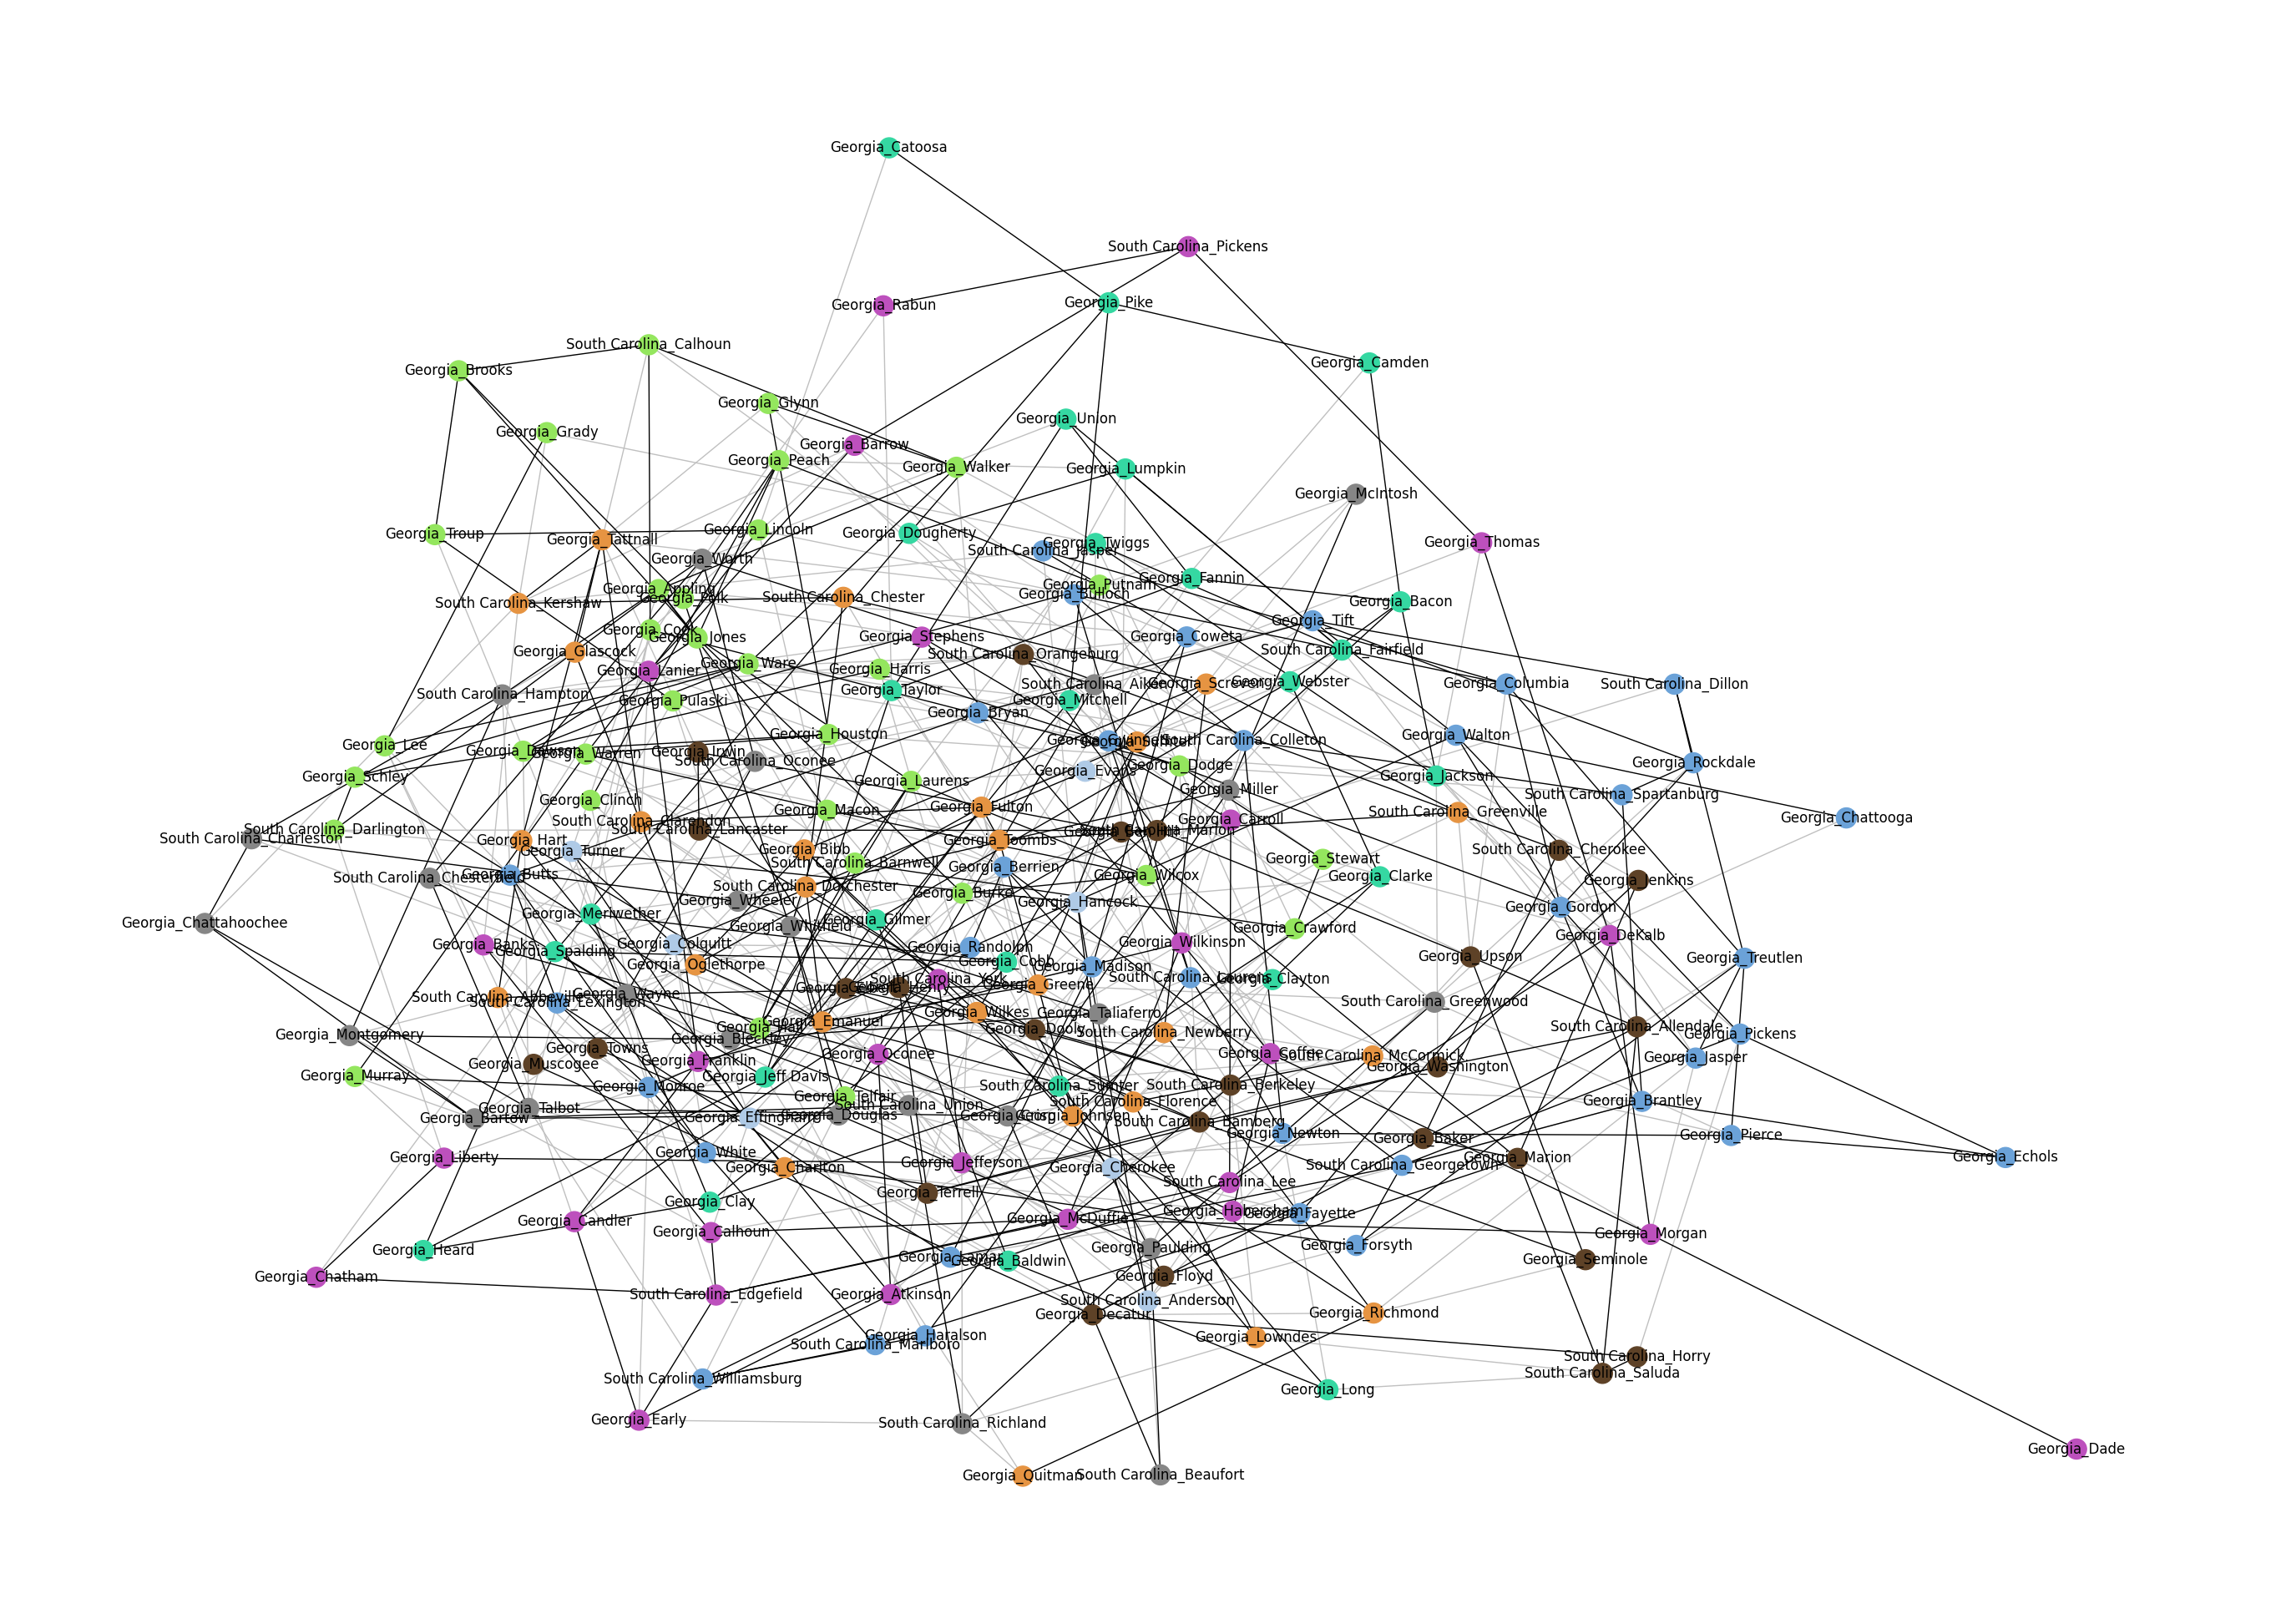

The network has 1 communities with Label Propagation.
0.010617733001708984


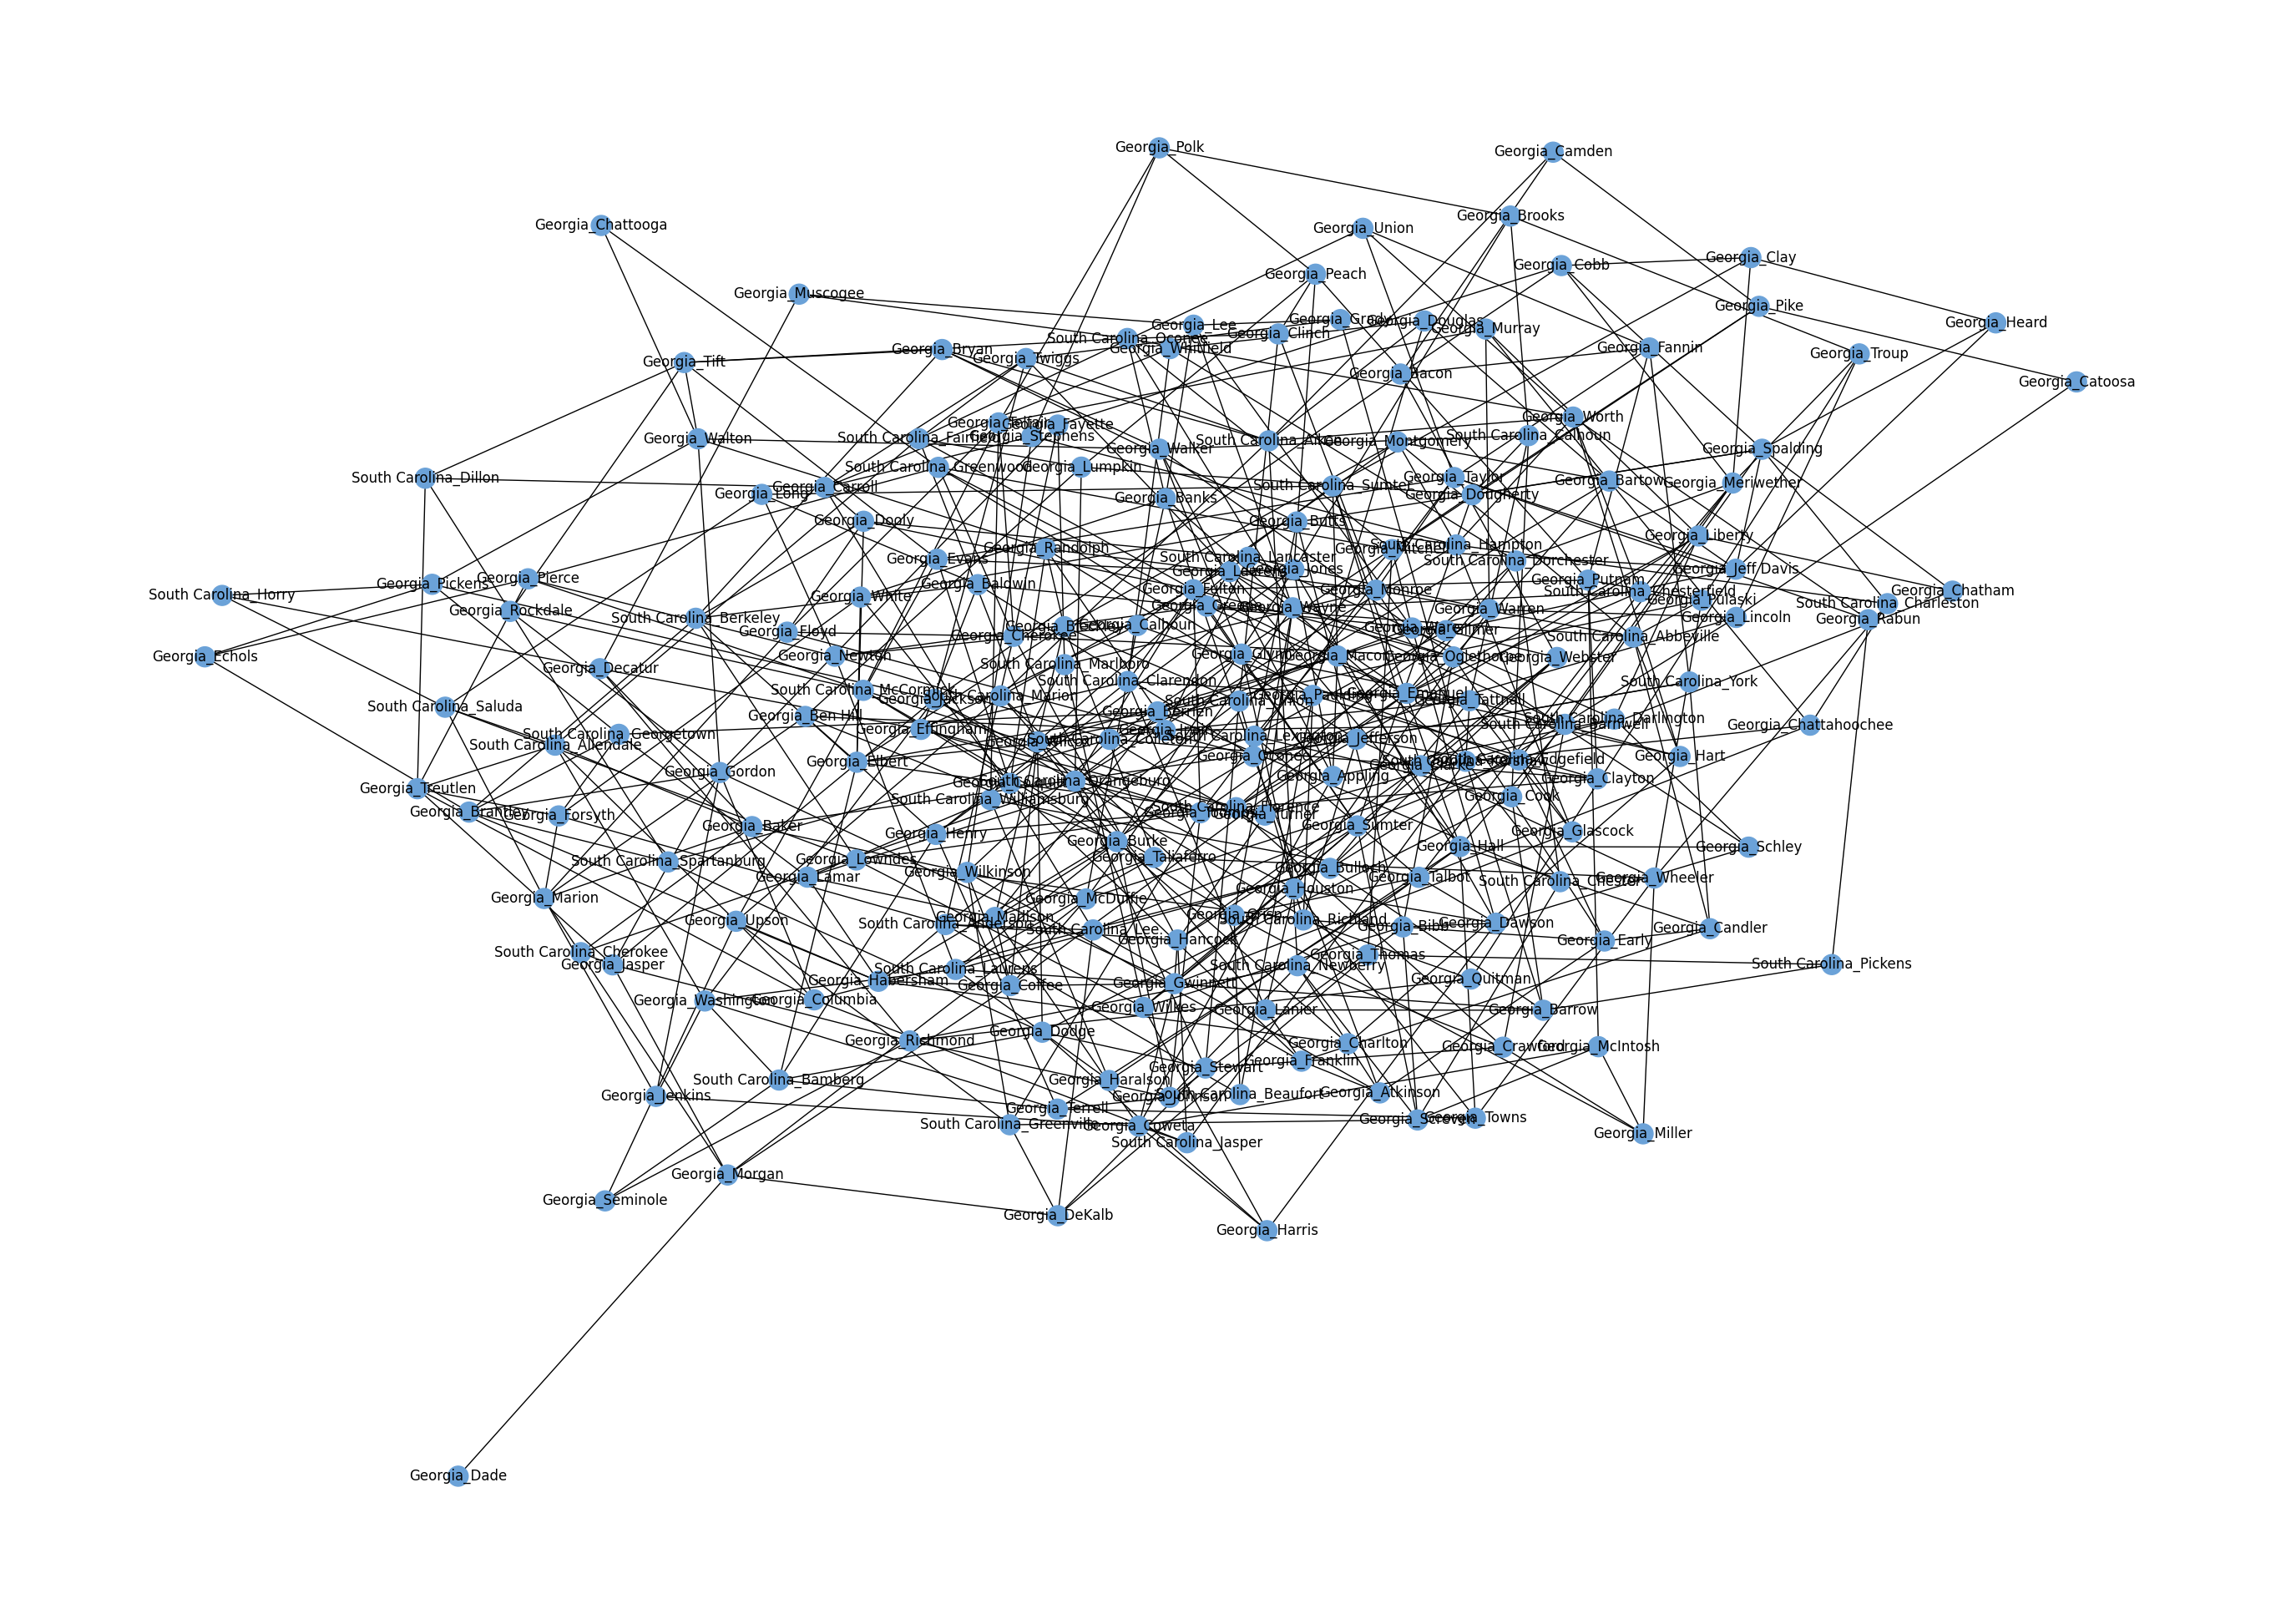

In [41]:
# community detection on the randomised network
GR = nx.random_reference(G, niter=100, connectivity=False)
f(GR)

Community Detection: Treat the counties as nodes in a network and detect communities (regions with similar NTL patterns over time).
What to look for: Temporal patterns of communities (do certain groups of counties have similar lighting trends over time?).
Visualization: Community structure plot using methods like modularity optimization (e.g., Louvain or Girvan-Newman algorithms).
Correlation Networks: Build a correlation matrix to understand the relationships between different counties. The counties with highly correlated NTL patterns can be linked together in the network.
What to look for: Strong positive or negative correlations between regions' NTL over time.
Visualization: Heatmap or network graph where nodes (counties) are connected based on the strength of their correlation.

# TODO: comment, analysis and why

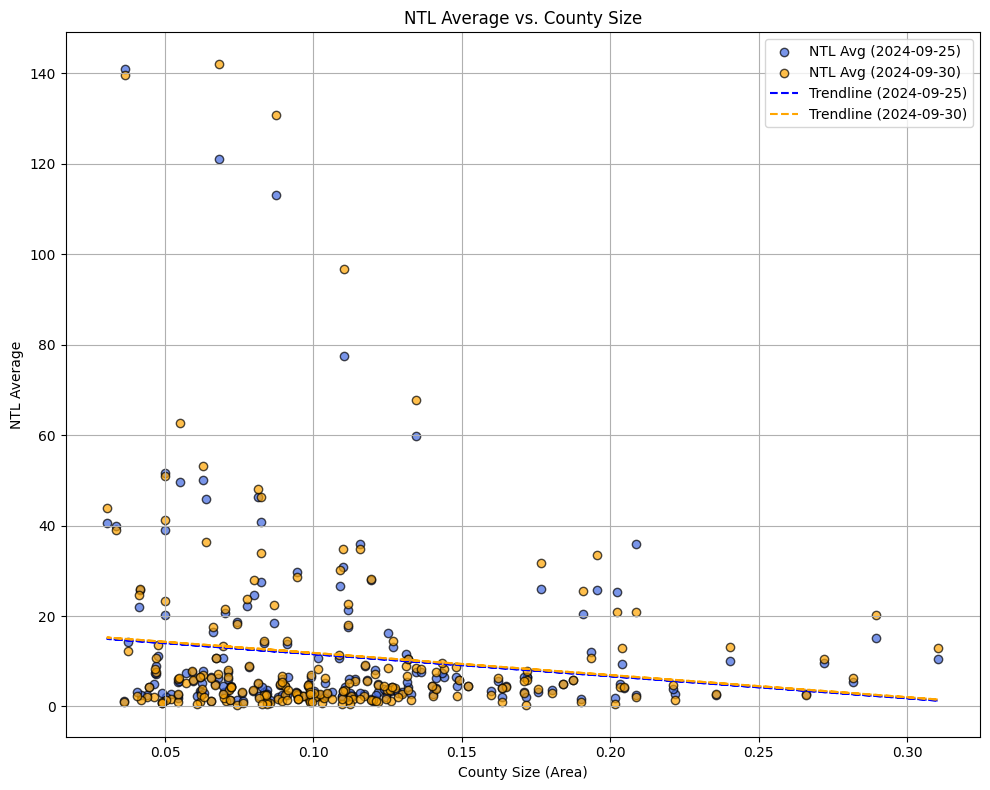

In [38]:
import matplotlib.pyplot as plt
import ast  # For safely parsing string representations of dictionaries
from shapely import wkt
import numpy as np

# Extract area and NTL average data
areas = {}
ntl_avgs = {}

# Dates to use for NTL average
target_date_1 = '2024-09-25'
target_date_2 = '2024-09-30'

for node, data in G.nodes(data=True):
    # Compute county area
    if "geometry" in data:
        try:
            geometry = wkt.loads(data["geometry"])  # Parse WKT geometry
            areas[node] = geometry.area
        except Exception as e:
            print(f"Error processing geometry for node {node}: {e}")
            continue
    
    # Extract NTL average for the target dates
    if "ntl" in data:
        try:
            ntl_data = ast.literal_eval(data["ntl"])  # Parse NTL data
            ntl_avgs[node] = {
                target_date_1: ntl_data.get(target_date_1, {}).get(f"{target_date_1}_avg", 0),
                target_date_2: ntl_data.get(target_date_2, {}).get(f"{target_date_2}_avg", 0)
            }
        except Exception as e:
            print(f"Error processing NTL data for node {node}: {e}")

# Ensure matched nodes for plotting
common_nodes = set(areas.keys()) & set(ntl_avgs.keys())
areas_filtered = [areas[node] for node in common_nodes]
ntl_avgs_filtered_1 = [ntl_avgs[node][target_date_1] for node in common_nodes]
ntl_avgs_filtered_2 = [ntl_avgs[node][target_date_2] for node in common_nodes]

# Plot NTL average vs. county size for the first date
plt.figure(figsize=(10, 8))
plt.scatter(areas_filtered, ntl_avgs_filtered_1, alpha=0.7, edgecolors='k', c='royalblue', label=f'NTL Avg ({target_date_1})')

# Plot NTL average vs. county size for the second date
plt.scatter(areas_filtered, ntl_avgs_filtered_2, alpha=0.7, edgecolors='k', c='orange', label=f'NTL Avg ({target_date_2})')

# Add a trendline for the first date (optional)
z1 = np.polyfit(areas_filtered, ntl_avgs_filtered_1, 1)
p1 = np.poly1d(z1)
plt.plot(areas_filtered, p1(areas_filtered), "b--", label=f"Trendline ({target_date_1})")

# Add a trendline for the second date (optional)
z2 = np.polyfit(areas_filtered, ntl_avgs_filtered_2, 1)
p2 = np.poly1d(z2)
plt.plot(areas_filtered, p2(areas_filtered), "orange", linestyle='--', label=f"Trendline ({target_date_2})")

# Customize plot
plt.title("NTL Average vs. County Size")
plt.xlabel("County Size (Area)")
plt.ylabel("NTL Average")
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


# INTERPRETATION 
The trend does not really change from the first date to the second --> there has not been a drastic change in the ntl averages after the hurricane

Correlation between NTL differences of neighboring counties in Georgia: 0.48082629330671645


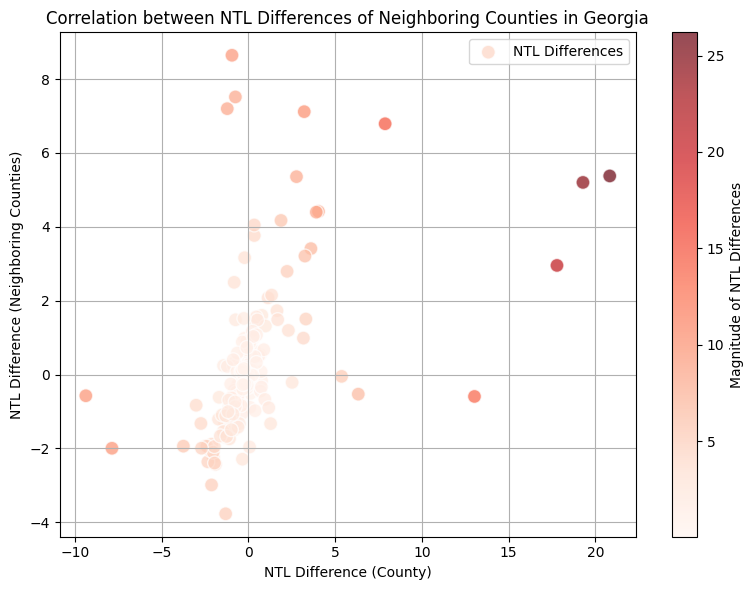

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import ast
from shapely import wkt

# Load the GML file
file_path = 'county_graph_with_ntl.gml'
G = nx.read_gml(file_path)

# Extract NTL Data for Specific Dates (2024-09-25 and 2024-09-30)
target_dates = ['2024-09-25', '2024-09-30']
differences = {}

# Extract county geometries and NTL average values for the two dates
for node, data in G.nodes(data=True):
    geometry_wkt = data.get('geometry', None)
    ntl_data = data.get('ntl', None)  # Get NTL data (assumed to be a dictionary or string)
    
    if geometry_wkt and ntl_data:
        try:
            # Parse the geometry
            geometry = wkt.loads(geometry_wkt)
            
            # Convert NTL data to dictionary safely and calculate the difference
            ntl_dict = ast.literal_eval(ntl_data)  # Safely evaluate string dictionary
            before = ntl_dict.get(target_dates[0], {}).get(f"{target_dates[0]}_avg", 0)
            after = ntl_dict.get(target_dates[1], {}).get(f"{target_dates[1]}_avg", 0)
            difference = after - before
            differences[node] = difference
        except Exception as e:
            print(f"Error processing node {node}: {e}")

# Filter for counties in Georgia (assuming Georgia counties are defined or have a naming pattern)
georgia_counties = [node for node, data in G.nodes(data=True) if 'Georgia' in node]

# Calculate the NTL differences for neighboring counties
correlations = []
for county in georgia_counties:
    # Get neighbors of the county as a list
    neighbors = list(G.neighbors(county))
   
    n_diff = []
    for neighbor in neighbors:
        if neighbor in georgia_counties:  # Ensure the neighbor is also in Georgia
            # Get the difference between the dates of the county
            county_diff = differences.get(county, 0)
            # As well as from the neighbor
            neighbor_diff = differences.get(neighbor, 0)
            n_diff.append(neighbor_diff)
    
    # Calculate average NTL difference of neighbors
    if n_diff:
        avg_neighbor_diff = sum(n_diff) / len(n_diff)
        correlations.append((county_diff, avg_neighbor_diff))

# Convert the correlations to a NumPy array and calculate correlation
correlations = np.array(correlations)

# Calculate the correlation between the NTL differences of neighboring counties
if len(correlations) > 0:
    corr_coef = np.corrcoef(correlations[:, 0], correlations[:, 1])[0, 1]
    print(f"Correlation between NTL differences of neighboring counties in Georgia: {corr_coef}")
else:
    print("No valid correlations found between neighboring counties.")

# Plot the NTL differences of neighboring counties
plt.figure(figsize=(8, 6))

# Scatter plot with color scheme
c = np.abs(correlations[:, 0]) + np.abs(correlations[:, 1])  # Intensity based on magnitude
plt.scatter(
    correlations[:, 0], 
    correlations[:, 1], 
    c=c, cmap='Reds', alpha=0.7, edgecolors='w', s=100, label='NTL Differences'
)

# Add labels and title
plt.xlabel("NTL Difference (County)")
plt.ylabel("NTL Difference (Neighboring Counties)")
plt.title("Correlation between NTL Differences of Neighboring Counties in Georgia")
plt.colorbar(label="Magnitude of NTL Differences")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# Interpretation: todo

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import ast  # Import for safely evaluating strings as Python objects

# Compute Centrality Measures
centrality_measures = {
    "degree": nx.degree_centrality(G),
    "closeness": nx.closeness_centrality(G),
    "betweenness": nx.betweenness_centrality(G)
}

# Print top counties for each centrality measure
def print_top_centralities(centrality_dict, measure_name, top_n=5):
    print(f"Top {top_n} counties by {measure_name} centrality:")
    sorted_centralities = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    for county, value in sorted_centralities:
        print(f"  {county}: {value:.4f}")

for measure_name, centrality_dict in centrality_measures.items():
    print_top_centralities(centrality_dict, measure_name)

# Identify Key Regions (Hubs) using NTL Data
# Use average NTL as a proxy for identifying economic hubs
ntl_avg_values = {}
for node, data in G.nodes(data=True):
    ntl_data = data.get('ntl')
    if ntl_data:
        try:
            # Parse NTL data string into a dictionary
            ntl_dict = ast.literal_eval(ntl_data)
            avg_ntl = sum(ntl_dict[date][f'{date}_avg'] for date in ntl_dict) / len(ntl_dict)
            ntl_avg_values[node] = avg_ntl
        except Exception as e:
            print(f"Error processing NTL data for node {node}: {e}")

# Find top 5 economic hubs
top_hubs = sorted(ntl_avg_values.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 economic hubs based on average NTL:")
for hub, avg_ntl in top_hubs:
    print(f"  {hub}: {avg_ntl:.2f}")


Top 5 counties by degree centrality:
  Georgia_Emanuel: 0.0539
  Georgia_Fulton: 0.0490
  Georgia_Hall: 0.0441
  South Carolina_Orangeburg: 0.0441
  Georgia_Burke: 0.0392
Top 5 counties by closeness centrality:
  Georgia_Emanuel: 0.1971
  Georgia_Laurens: 0.1965
  Georgia_Johnson: 0.1950
  Georgia_Twiggs: 0.1947
  Georgia_Jefferson: 0.1945
Top 5 counties by betweenness centrality:
  Georgia_Emanuel: 0.2723
  Georgia_Burke: 0.1775
  Georgia_Laurens: 0.1611
  Georgia_Fulton: 0.1265
  South Carolina_Aiken: 0.1256
Top 5 economic hubs based on average NTL:
  Georgia_Clayton: 154.80
  Georgia_DeKalb: 149.24
  Georgia_Cobb: 139.68
  Georgia_Gwinnett: 103.77
  Georgia_Fulton: 68.22


# TODO: interpretation

In [15]:
# 5. Assortativity Coefficient based on NTL for Specific Dates
# Ensure each node has an 'ntl_avg' attribute based on the specific dates ['2024-09-25', '2024-09-30']
specific_dates = ['2024-09-25', '2024-09-30']
for node in G.nodes():
    if 'ntl' in G.nodes[node]:
        ntl_values = [G.nodes[node]['ntl'][date][f'{date}_avg'] for date in specific_dates if date in G.nodes[node]['ntl']]
        G.nodes[node]['ntl_avg'] = sum(ntl_values) / len(ntl_values) if ntl_values else 0
    else:
        G.nodes[node]['ntl_avg'] = 0  # Default value if no NTL data

# Calculate assortativity based on 'ntl_avg'
assortativity = nx.numeric_assortativity_coefficient(G, "ntl_avg")
print(f"Assortativity coefficient based on NTL average for dates {specific_dates}: {assortativity:.4f}")

Assortativity coefficient based on NTL average for dates ['2024-09-25', '2024-09-30']: 0.5262


The assortativity coefficient of 0.5262 in your network indicates a moderate **positive correlation** between the NTL (Nighttime Light) averages of neighboring counties. This suggests that:
- Bright Counties Cluster Together: Counties with higher NTL values (indicative of more light emissions) tend to be connected to other counties with similarly high NTL values.
- Spatial or Economic Patterns: The result reflects potential geographic or socioeconomic clustering, where regions with higher development (as inferred from NTL) are likely adjacent to each other.
- But still, as the assortativity value is not that close to the maximum assortativity value of 1, while there is a significant positive relationship, it's not absolute. There are still connections between counties with differing NTL levels.